In [41]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %%
from IPython import get_ipython


 ## Install TensorTrade

In [42]:
#!python3 -m pip install git+https://github.com/tensortrade-org/tensortrade.git
import inspect
import sys
import os
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, "{}".format(parentdir))
currentdir



'd:\\MyWork\\StocksTrading\\Sandboxes\\AutoTrader\\tensortrade\\examples'

 ## Setup Data Fetching

In [43]:
import pandas as pd
import tensortrade.env.default as default

from tensortrade.data.cdd import CryptoDataDownload
from tensortrade.feed.core import Stream, DataFeed
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC, ETH, AAPL
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.agents import DQNAgent
from tensortrade.env.default.renderers import PlotlyTradingChart, FileLogger, MatplotlibTradingChart

import gym
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpPolicy, MlpLnLstmPolicy
from stable_baselines import DQN, PPO2, A2C

get_ipython().run_line_magic('matplotlib', 'inline')

# Use these commands - to reload sources, while development
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2020-12-11 23:54:03,358 [DEBUG : data_feed.py: 96 ]: Loading quotes from a file: D:\MyWork\StocksTrading\Sandboxes\AutoTrader\data\stock_data\AAPL_1D_2010-01-01_2020-12-10.csv
2020-12-11 23:54:03,377 [DEBUG : utils.py: 22 ]: utils.data_feed.QuotesLoader.get_quotes: took 0.0180 sec


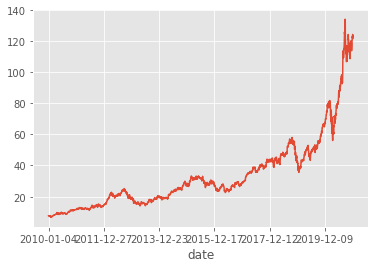

In [44]:
# Use Data-Feed from Yahoo Finance
sys.path.insert(0, "{}".format("D:\MyWork\StocksTrading\Sandboxes\AutoTrader"))
from utils import YahooQuotesLoader

symbol = 'AAPL'
exchange = 'NASDAQ'
start_date = '2010-01-01'
end_date = '2020-12-10'
quotes = YahooQuotesLoader.get_quotes(
        symbol=symbol,
        date_from=start_date,
        date_to=end_date,
    )
quotes.drop(columns=["index","unnamed: 0","adj close","volume"],inplace=True)
quotes.set_index("date",inplace=True)
quotes['close'].plot()



In [45]:

import ta
import numpy as np
# custom ta-Features
# Check https://github.com/bukosabino/ta
# Visualization: https://github.com/bukosabino/ta/blob/master/examples_to_use/visualize_features.ipynb
def add_custom_ta_features(
    df: pd.DataFrame,
    open: str,  # noqa
    high: str,
    low: str,
    close: str,
    fillna: bool = False,
    colprefix: str = "",
) -> pd.DataFrame:

    df = ta.add_volatility_ta(
        df=df, high=high, low=low, close=close, fillna=fillna, colprefix=colprefix
    )
    df = ta.add_trend_ta(
        df=df, high=high, low=low, close=close, fillna=fillna, colprefix=colprefix
    )
    df = ta.add_others_ta(df=df, close=close, fillna=fillna, colprefix=colprefix)
    return df

# get ta-indicators
quotes_ta = add_custom_ta_features(quotes,"open","high","low","close", fillna=True)

# convert to pct
#data = quotes_ta.pct_change(fill_method ='ffill')
data = quotes_ta
data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(value=0)
data.reset_index(inplace=True)
data.tail()




,date,high,low,open,close,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,...,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,others_dr,others_dlr,others_cr
2750,2020-12-04,122.860001,121.519997,122.599998,122.250000,2.750549,118.7160,123.878561,113.553439,8.697330,...,92.0,8.0,84.0,113.451211,121.437203,0.0,0.0,-0.561251,-0.562832,1499.457982
2751,2020-12-07,124.570000,122.250000,122.309998,123.750000,2.707494,118.9690,124.578287,113.359713,9.429829,...,100.0,4.0,96.0,113.864362,121.437203,0.0,0.0,1.226994,1.219527,1519.083233
2752,2020-12-08,124.980003,123.089996,124.370003,124.379997,2.625745,119.3720,125.310586,113.433414,9.949713,...,100.0,4.0,96.0,114.506700,121.437203,0.0,0.0,0.509089,0.507797,1527.325803
2753,2020-12-09,125.949997,121.000000,124.529999,121.779999,2.858170,119.6625,125.474058,113.850941,9.713250,...,96.0,56.0,40.0,115.344565,121.437203,0.0,0.0,-2.090367,-2.112525,1493.308720
2754,2020-12-10,123.870003,120.150002,120.500000,123.239998,2.944353,119.8500,125.865591,113.834409,10.038533,...,92.0,52.0,40.0,116.405108,121.437203,0.0,0.0,1.198882,1.191753,1512.410620


In [48]:
from scipy.signal import argrelextrema
import numpy as np

# get Min/Max TimeStamps
df_min_ts = data.iloc[argrelextrema(data.close.values, np.less_equal, order=7)[0]]#['date']
df_max_ts = data.iloc[argrelextrema(data.close.values, np.greater_equal, order=7)[0]]#['date']


In [49]:
# Plot Min/Max with Plotly
import plotly.graph_objects as go

#fig = go.Figure(data=[go.Candlestick(x=data['date'],
#                open=data['open'],
#                high=data['high'],
#                low=data['low'],
#                close=data['close'])])
fig = go.Figure(data= go.Scatter(
    x=data['date'],
    y=data['close'],
    name='Original Data'
))
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])                
fig.add_trace(go.Scatter(mode="markers", x=df_min_ts['date'], y=df_min_ts['close'], name="min",marker_color='rgba(0, 255, 0, .9)'))
fig.add_trace(go.Scatter(mode="markers", x=df_max_ts['date'], y=df_max_ts['close'], name="max",marker_color='rgba(255, 0, 0, .9)'))

config = {'displayModeBar': False}
fig.show(config=config)


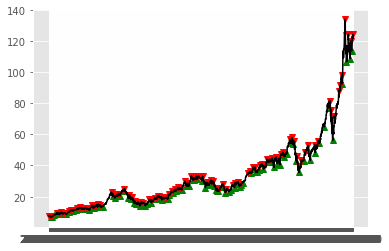

In [50]:
import matplotlib.pyplot as plt
#plt.scatter(df_min_ts.index, df_min_ts['close'], c='g')
plt.plot(df_min_ts.index, df_min_ts['close'], '^', color='green')
plt.plot(df_max_ts.index, df_max_ts['close'], 'v', color='red')
plt.plot(data['date'], data['close'], color='black')
plt.show()


In [51]:
features = []
#exclude date from observation - start from column 1
for c in data.columns[1:]:
    s = Stream.source(list(data[c]), dtype="float").rename(data[c].name)
    features += [s]
feed = DataFeed(features)
feed.compile()
for i in range(5):
    #print(feed.next())
    pass


In [52]:
# Make a stream of closing prices to make orders on
from tensortrade.oms.instruments import Instrument, Quantity
import tensortrade.env.default as default

def create_trade_env(data,symbol):

  # define exchange
  exchange  = Exchange("sim-exchange", service=execute_order)(
      Stream.source(list(data["close"]), dtype="float").rename(str("USD-{}").format(symbol))
  )

  # add current cash, initial-asset
  cash = Wallet(exchange, 100000 * USD)
  asset = Wallet(exchange, 0 * Instrument(symbol, 2, symbol))

  # initialize portfolio - base currency USD
  portfolio = Portfolio(
      base_instrument = USD, 
      wallets = [
          cash,
          asset
      ]
  )

  # add element for rendered feed
  renderer_feed = DataFeed([
      Stream.source(list(data["date"])).rename("date"),
      Stream.source(list(data["open"]), dtype="float").rename("open"),
      Stream.source(list(data["high"]), dtype="float").rename("high"),
      Stream.source(list(data["low"]), dtype="float").rename("low"),
      Stream.source(list(data["close"]), dtype="float").rename("close")
      #Stream.source(list(data["volume"]), dtype="float").rename("volume") 
  ])

  # define reward-scheme
  reward_scheme = default.rewards.SimpleProfit()

  # define action-scheme
  action_scheme = default.actions.BSH(
      cash=cash,
      asset=asset
  )

  # create env
  env = default.create(
      portfolio=portfolio,
      action_scheme=action_scheme,
      reward_scheme=reward_scheme,
      feed=feed,
      renderer_feed=renderer_feed,
      #renderer="screen-log",
      #window_size=20,
      max_allowed_loss=0.6
  )

  return env

env = create_trade_env(data,symbol)



In [53]:
env.observer.feed.next()


{'internal': {'sim-exchange:/USD-AAPL': 7.643214225769043,
  'sim-exchange:/USD:/free': 100000.0,
  'sim-exchange:/USD:/locked': 0.0,
  'sim-exchange:/USD:/total': 100000.0,
  'sim-exchange:/AAPL:/free': 0.0,
  'sim-exchange:/AAPL:/locked': 0.0,
  'sim-exchange:/AAPL:/total': 0.0,
  'sim-exchange:/AAPL:/worth': 0.0,
  'net_worth': 100000.0},
 'external': {'high': 7.660714149475098,
  'low': 7.585000038146973,
  'open': 7.622499942779541,
  'close': 7.643214225769043,
  'volatility_atr': 0.0,
  'volatility_bbm': 7.643214225769043,
  'volatility_bbh': 7.643214225769043,
  'volatility_bbl': 7.643214225769043,
  'volatility_bbw': 0.0,
  'volatility_bbp': 0.0,
  'volatility_bbhi': 0.0,
  'volatility_bbli': 0.0,
  'volatility_kcc': 7.629642804463704,
  'volatility_kch': 7.705356915791829,
  'volatility_kcl': 7.553928693135579,
  'volatility_kcw': 1.9847354134017554,
  'volatility_kcp': 0.5896227999462602,
  'volatility_kchi': 0.0,
  'volatility_kcli': 0.0,
  'volatility_dcl': 0.9906056417057

In [54]:
breakpoint()
# ## Generate Expert Trajectories
import gym

from stable_baselines.gail import generate_expert_traj
from tensortrade.oms.orders import (
    Order,
    proportion_order,
    TradeSide,
    TradeType
)
global_index = 4
global_last_action = 0

# Here the expert is a random agent
# but it can be any python function, e.g. a PID controller
def expert_trader(_obs):
    """
    Random agent. It samples actions randomly
    from the action space of the environment.

    :param _obs: (np.ndarray) Current observation
    :return: (np.ndarray) action taken by the expert
    """
    global df_min_ts
    global df_max_ts
    global global_last_action

    is_buy_action = not (df_min_ts.loc[(df_min_ts['high'] == _obs[0][0]) & 
           (df_min_ts['low'] == _obs[0][1])  &
           (df_min_ts['open'] == _obs[0][2])  &
           (df_min_ts['close'] == _obs[0][3])
    ].empty)

    is_sell_action = not (df_max_ts.loc[(df_max_ts['high'] == _obs[0][0]) & 
           (df_max_ts['low'] == _obs[0][1])  &
           (df_max_ts['open'] == _obs[0][2])  &
           (df_max_ts['close'] == _obs[0][3])
        ].empty)

    if is_buy_action:
        #perform buy action
        global_last_action = 1
    elif is_sell_action:
        #perform sell action
        global_last_action = 0
    else:
        #do nothing
        pass

    return global_last_action
# Data will be saved in a numpy archive named `expert_cartpole.npz`
# when using something different than an RL expert,
# you must pass the environment object explicitly
generate_expert_traj(expert_trader, 'expert_trader', env, n_episodes=10)
pass


actions (27540, 1)
obs (27540, 1, 57)
rewards (27540,)
episode_returns (10,)
episode_starts (27540,)


actions (27540, 1)
obs (27540, 1, 57)
rewards (27540,)
episode_returns (10,)
episode_starts (27540,)
Total trajectories: 1
Total transitions: 5506
Average returns: 4.005752010104812
Std for returns: 0.0008152261028429919


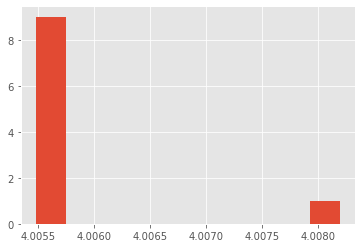

In [63]:
# Pre-Train a Model using Behavior Cloning
from stable_baselines.gail import ExpertDataset
# Using only one expert trajectory
# you can specify `traj_limitation=-1` for using the whole dataset
dataset = ExpertDataset(expert_path='expert_trader.npz',
                        traj_limitation=1, batch_size=128)
dataset.plot()


In [68]:
# PPO2-Model
from stable_baselines.common.policies import MlpPolicy, MlpLnLstmPolicy
agent = PPO2(MlpPolicy, env, verbose=1)
# Pretrain the PPO2 model
agent.pretrain(dataset, n_epochs=100)

# As an option, you can train the RL agent
# model.learn(int(1e5))
agent.save(save_path=os.path.join(currentdir, "agents","BC_PPO2_MlpPolicy.zip"))



Wrapping the env in a DummyVecEnv.
Pretraining with Behavior Cloning...
